# Here we look for the best model possible in order to forecast daily baseload price

In [2]:
import pandas as pd

# just a copy of the previous funciton to load and clean our dataset

def clean_data(path1, path2):
    """
    We call this function everytime after reading the 2 csv files if we want to clean our data.
    This function removes the outliers which are error in annotations (outlier gas price) and fill Nan values.
    """

    # We load the dataframes and rename Unnamed: 0 in time(hour) and time(day)
    path = "/home/lucien/Bureau/Lucien_Rondier_Work/data/"
    df1 = pd.read_csv(path + path1)
    df2 = pd.read_csv(path + path2)
    df1 = df1.rename(columns={'Unnamed: 0': 'time(hour)'})
    df2 = df2.rename(columns={'Unnamed: 0': 'time(day)'})

    # We clean df1: this is just a forward fill on 3 columns (see the previous notebook to see why)
    df1[['power.de.avail.aggr.lignite.mw.h.obs.cet.3mv', 
    'power.de.avail.aggr.nuclear.mw.h.obs.cet.3mv', 
    'power.de.avail.aggr.coal.mw.h.obs.cet.3mv']] = df1[['power.de.avail.aggr.lignite.mw.h.obs.cet.3mv', 
                                                        'power.de.avail.aggr.nuclear.mw.h.obs.cet.3mv', 
                                                        'power.de.avail.aggr.coal.mw.h.obs.cet.3mv']].ffill()

    # We clean df2: we delete an outlier and make forward fill and then one backward fill
    target_date = '2023-04-11' # target 
    target_index = df2[df2['time(day)'] == target_date].index[0]
    df2.loc[target_index, 'price.naturalgas.ncg.delivery.powernext.eur.mwh'] = df2.loc[target_index - 1, 'price.naturalgas.ncg.delivery.powernext.eur.mwh']

    df2[['power.price.co2.eua.eurot.d.obs', 'coal.price.api2_ara.euromwh.d.obs']] = df2[
        ['power.price.co2.eua.eurot.d.obs', 'coal.price.api2_ara.euromwh.d.obs']
    ].ffill()

    df2[['power.price.co2.eua.eurot.d.obs', 'coal.price.api2_ara.euromwh.d.obs']] = df2[
        ['power.price.co2.eua.eurot.d.obs', 'coal.price.api2_ara.euromwh.d.obs']
    ].bfill()

    # Now we concatenate the two dataframes, repeating the 3 same prices of the day for every hour thanks to a left join

    df1['time(day)'] = pd.to_datetime(df1['time(hour)']).dt.date

    # Conversion de la colonne 'time(day)' de df2 au format date pour correspondre à df1
    df2['time(day)'] = pd.to_datetime(df2['time(day)']).dt.date

    # join df1 and df2
    df_merged = pd.merge(df1, df2, on='time(day)', how='left')

    # we delete the day time column
    df_merged = df_merged.drop(columns=['time(day)'])

    return df_merged

## 1) Benchmark model and feature selection: linear regression with Lasso

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load and clean the data
path1, path2 = "data1.csv", "data2.csv"
df = clean_data(path1, path2)

# Separate target column from the features
target_column = 'power.de.price.day_ahead.euromwh.h.obs.cet.epex'
features = df.columns.difference(['time(hour)'])

# Scale both features and the target column
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Store the unscaled target column for later MAE calculation
unscaled_target = df[target_column].values

# Number of hours we look back
lookback = 5

# Prepare the window of annotated data to make multivariate predictions
X, y = [], []
for i in range(len(df_scaled) - lookback):
    X.append(df_scaled.iloc[i:i+lookback][features].values)
    y.append(unscaled_target[i + lookback])  # Use unscaled target for MAE

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Flatten X for Lasso (Lasso requires 2D input)
n_samples, lookback, n_features = X.shape
X_flat = X.reshape(n_samples, lookback * n_features)

# Split into training and testing sets without shuffling
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, shuffle=False)

# Initialize and train Lasso regression model
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(X_test)

# Calculate the Mean Absolute Error (MAE) on the original (unscaled) test set
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on test set (original scale):", mae)


Mean Absolute Error on test set (original scale): 16.142500095442383


In [34]:
import plotly.graph_objects as go

# Plot predictions vs actual values with Plotly
fig = go.Figure()

# Add the actual values
fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test,
                         mode='lines+markers', name='Actual Values', line=dict(color='blue')))

# Add the predicted values
fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_pred,
                         mode='lines+markers', name='Predicted Values', line=dict(color='red', dash='dash')))

# Update layout
fig.update_layout(
    title="Lasso Regression Predictions vs Actual Values",
    xaxis_title="Sample Index",
    yaxis_title="Power Price (EUR/MWh)",
    legend_title="Legend",
    height=500
)

fig.show()

In [35]:
# Assuming X, y, X_train, X_test, y_train, y_test, and the trained Lasso model already exist
# Predict on the test set
y_pred = lasso_model.predict(X_test)

# Calculate Mean Absolute Error (optional, for reference)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on test set:", mae)

# Calculate Direction Accuracy
# Determine the direction of price movement for both actual and predicted values
actual_direction = np.sign(np.diff(y_test))  # +1 for increase, -1 for decrease
predicted_direction = np.sign(np.diff(y_pred))  # +1 for increase, -1 for decrease

# Calculate accuracy of direction prediction
direction_accuracy = np.mean(actual_direction == predicted_direction) * 100
print("Direction Accuracy (up/down prediction):", direction_accuracy, "%")


Mean Absolute Error on test set: 16.142500095442383
Direction Accuracy (up/down prediction): 72.25935828877004 %


## 2) XGBoost: a model that handles complex data structures like time series

In [36]:
import numpy as np

# we load and clean the data

path1, path2 = "data1.csv", "data2.csv"
df = clean_data(path1, path2)

# number of hours we look at
lookback = 5

# We prepare the window of annotated data to make multivariate prediction
X, y = [], []
for i in range(len(df) - lookback):
    X.append(df.iloc[i:i+lookback].drop(columns=['time(hour)']).values)
    y.append(df.iloc[i + lookback]['power.de.price.day_ahead.euromwh.h.obs.cet.epex'])  # Value at the following hour

# We convert into a numpy tab
X, y = np.array(X), np.array(y)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Flatten X for XGBRegressor (it requires 2D input)
n_samples, lookback, n_features = X.shape
X_flat = X.reshape(n_samples, lookback * n_features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, shuffle=False)

# Initialize, train, and predict with XGBRegressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate and display the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on test set:", mae)

Mean Absolute Error on test set: 12.262248814453526


In [38]:
import plotly.graph_objects as go

# Créer un DataFrame pour organiser les vraies valeurs et les prédictions
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Créer un graphique avec Plotly
fig = go.Figure()

# Ajouter les vraies valeurs
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'],
                         mode='lines+markers',
                         name='Actual Values'))

# Ajouter les valeurs prédites
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'],
                         mode='lines+markers',
                         name='Predicted Values'))

# Mettre à jour la mise en page du graphique
fig.update_layout(title='Comparison of Actual and Predicted Values',
                  xaxis_title='Test Sample Index',
                  yaxis_title='Value',
                  legend_title='Legend')

# Afficher le graphique
fig.show()

In [8]:
from deap import base, creator, tools, algorithms
import random

# Define the hyperparameter search space
def create_model(n_estimators, max_depth, learning_rate, subsample):
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("n_estimators", random.randint, 50, 300)
toolbox.register("max_depth", random.randint, 3, 10)
toolbox.register("learning_rate", random.uniform, 0.01, 0.3)
toolbox.register("subsample", random.uniform, 0.5, 1.0)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.learning_rate, toolbox.subsample), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    n_estimators, max_depth, learning_rate, subsample = individual
    return create_model(n_estimators, max_depth, learning_rate, subsample),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[50, 3, 0.01, 0.5], up=[300, 10, 0.3, 1.0], indpb=0.2, eta=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the genetic algorithm
def run_ga():
    try:
        population = toolbox.population(n=10)
        n_generations = 5
        
        for gen in range(n_generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
            fits = toolbox.map(toolbox.evaluate, offspring)
            
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            
            population = toolbox.select(offspring, k=len(population))
            top_individual = tools.selBest(population, k=1)[0]
            
            print(f"Generation {gen + 1}, Best MAE: {top_individual.fitness.values[0]}, Params: {top_individual}")
        
        best_individual = tools.selBest(population, k=1)[0]
        print("Best hyperparameters found:", best_individual)
        print("Best MAE achieved:", best_individual.fitness.values[0])
    except Exception:
        
        pass

run_ga()

Generation 1, Best MAE: 11.568979291127489, Params: [250.21389897560985, 3.5205700369602124, 0.10217853960827143, 0.8850236028230776]
Generation 2, Best MAE: 11.372914656047238, Params: [73.31328536761177, 5.0534574732398445, 0.1269505228415071, 0.6502517666505363]
Generation 3, Best MAE: 11.372914656047238, Params: [73.31328536761177, 5.0534574732398445, 0.1269505228415071, 0.6502517666505363]
Generation 4, Best MAE: 11.372914656047238, Params: [73.31328536761177, 5.0534574732398445, 0.1269505228415071, 0.6502517666505363]
Generation 5, Best MAE: 11.372914656047238, Params: [73.31328536761177, 5.0534574732398445, 0.1269505228415071, 0.6502517666505363]
Best hyperparameters found: [73.31328536761177, 5.0534574732398445, 0.1269505228415071, 0.6502517666505363]
Best MAE achieved: 11.372914656047238


In [39]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on test set:", mae)

# Calculate Direction Accuracy
# Determine the direction of price movement for both actual and predicted values
actual_direction = np.sign(np.diff(y_test))  # +1 for increase, -1 for decrease
predicted_direction = np.sign(np.diff(y_pred))  # +1 for increase, -1 for decrease

# Calculate accuracy of direction prediction
direction_accuracy = np.mean(actual_direction == predicted_direction) * 100
print("Direction Accuracy (up/down prediction):", direction_accuracy, "%")

Mean Absolute Error on test set: 12.262248814453526
Direction Accuracy (up/down prediction): 71.13970588235294 %


## 3) LSTM and neural network: the benefit of batches and a better understanding of the data structure.

In [10]:
import numpy as np

# we load and clean the data

path1, path2 = "data1.csv", "data2.csv"
df = clean_data(path1, path2)

# number of hours we look at
lookback = 5

# We prepare the window of annotated data to make multivariate prediction
X, y = [], []
for i in range(len(df) - lookback):
    X.append(df.iloc[i:i+lookback].drop(columns=['time(hour)']).values)
    y.append(df.iloc[i + lookback]['power.de.price.day_ahead.euromwh.h.obs.cet.epex'])  # Value at the following hour

# We convert into a numpy tab
X, y = np.array(X), np.array(y)

#### To be continued, unfortunately I had python librairies errors and no time to fix it...

## 4) When can we trust this model?

- a) We can find confidence interval for every predictions using the model

- b) We pair plot the error prediction and the derivative of every features to see in which context errors are most likely to happend

In [43]:
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go

# Predict the decision margins (assume `model` is trained)
y_pred_margin = model.predict(X_test, output_margin=True)

# Calculate confidence intervals
alpha = 0.05  # 95% confidence level
z = norm.ppf(1 - alpha / 2)  # Critical z-value for a 95% confidence level

# Calculate the standard deviation of residuals
residuals = y_test - y_pred
std_residuals = np.std(residuals)

# Compute confidence intervals
lower_bound = y_pred - z * std_residuals
upper_bound = y_pred + z * std_residuals

# Plot with Plotly
fig = go.Figure()

# Add the actual values line
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines',
    name='Actual Values',
    line=dict(color='blue')
))

# Add the predicted values line
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines',
    name='Predictions',
    line=dict(color='red', dash='dash')
))

# Add the pink confidence interval shading
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))) + list(range(len(y_pred))[::-1]),
    y=np.concatenate([upper_bound, lower_bound[::-1]]),
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.2)',  # Light pink color
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='95% Confidence Interval'
))

# Update layout
fig.update_layout(
    title="Predictions with 95% Confidence Interval",
    xaxis_title="Test Sample Index",
    yaxis_title="Value",
    legend_title="Legend",
    height=500
)

fig.show()


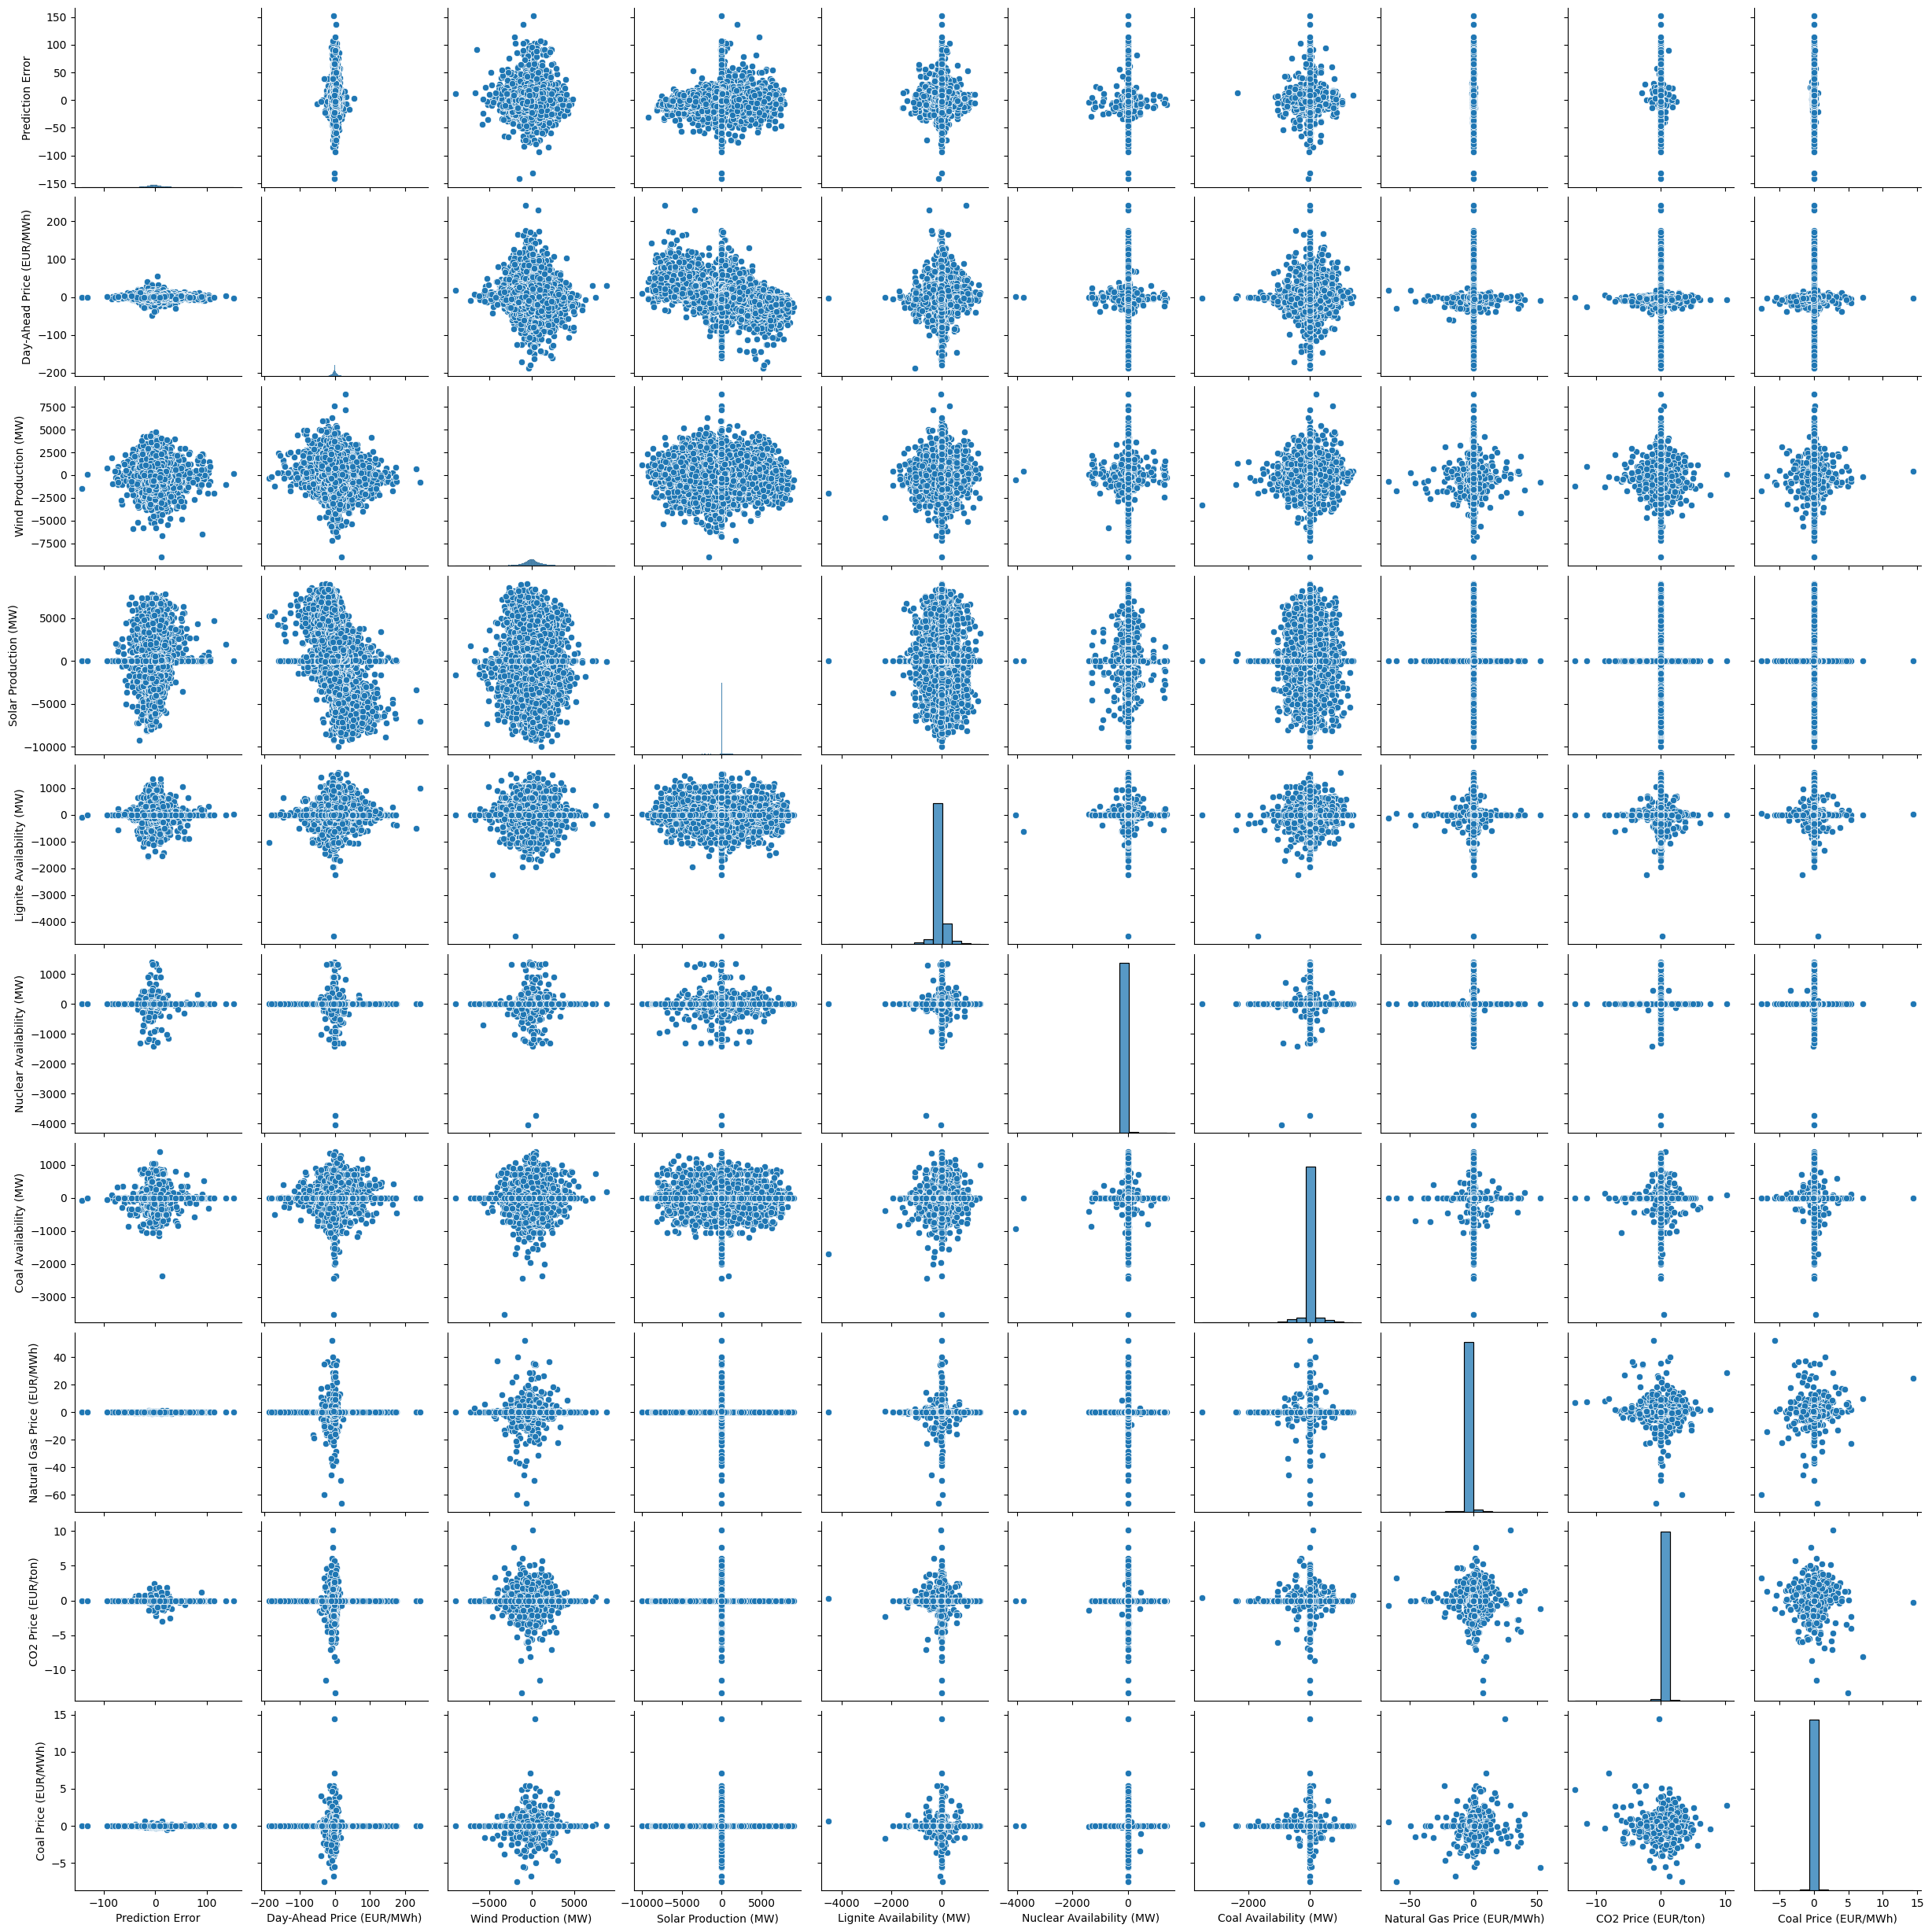

In [46]:
import seaborn as sns
import pandas as pd

# Filter the DataFrame to keep only the desired columns
filtered_df = df[['power.de.price.day_ahead.euromwh.h.obs.cet.epex', 
                  'power.prod.wind.de.mw.h.fcst.ecens.p50', 
                  'power.prod.solar.de.mw.h.fcst.ecens.p50', 
                  'power.de.avail.aggr.lignite.mw.h.obs.cet.3mv', 
                  'power.de.avail.aggr.nuclear.mw.h.obs.cet.3mv', 
                  'power.de.avail.aggr.coal.mw.h.obs.cet.3mv', 
                  'price.naturalgas.ncg.delivery.powernext.eur.mwh', 
                  'power.price.co2.eua.eurot.d.obs', 
                  'coal.price.api2_ara.euromwh.d.obs']]

# Calculate the prediction errors
errors = y_test - y_pred

# Calculate the derivative of the filtered features
filtered_derivatives = filtered_df.diff().dropna()

# Create a DataFrame for errors and derivatives
errors_df = pd.DataFrame(errors, columns=['Prediction Error'])
filtered_derivatives_df = filtered_derivatives.iloc[lookback:].reset_index(drop=True)

# Combine errors and derivatives into a single DataFrame
combined_df = pd.concat([errors_df.reset_index(drop=True), filtered_derivatives_df.reset_index(drop=True)], axis=1)

# Rename columns for better readability
combined_df.columns = ['Prediction Error', 'Day-Ahead Price (EUR/MWh)', 'Wind Production (MW)', 'Solar Production (MW)', 
                       'Lignite Availability (MW)', 'Nuclear Availability (MW)', 'Coal Availability (MW)', 
                       'Natural Gas Price (EUR/MWh)', 'CO2 Price (EUR/ton)', 'Coal Price (EUR/MWh)']

# Pair plot the errors and derivatives
sns.pairplot(combined_df)

#### Interpretation of the pair plot

**If we look at the first colum we can see how the error prediction vary depending on the feature:**

- for such feature it is totally independant: coal price, natural gas price and day ahead price. We can conclude that a brutal change in this features does not affect the error rate.

- some features tends to reduce the error rate when they brutally change like CO2 price, coal availability, solar production and wind production. These features improve the result of the model so when these feature ar evarying you can trust a little bit more your model.

- there is no feature that tend to improve the error rate (with a distribution on the left or on the right)

## 5) What inputs could we have added to improve this model?

- consumtion (data with linky smart meter)

- temperature

- Rainfall and Snowpack: Impacts hydroelectric power availability

- biomass stock: represents 8% of the energy mix dedicated to electricity in Germany.

- Market and State regulatory Factors: new Tax policy, emission regulation

- index on supply risk: huge fire in a country could impacts electricity distribution (In portugal this summer for instance).
